# 库导入

In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model

tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# 数据导入

In [2]:
style='Inc' # En状态量 or Inc变化量

index80 = 1

Intrain80 = np.load('data/%sIntrain%s.npy' % (style,index80))
Outtrain80 = np.load('data/%sOuttrain%s.npy' % (style,index80))

InLtrain80 = np.load('data/EnIntrain%s.npy' % index80)
OutLtrain80 = np.load('data/EnOutLtrain%s.npy' % index80)

Intest80 = np.load('data/%sIntest%s.npy' % (style,index80))
Outtest80 = np.load('data/%sOuttest%s.npy' % (style,index80))

InStest80 = np.load('data/EnIntest%s.npy' % index80)
OutLtest80 = np.load('data/EnOutLtest%s.npy' % index80)
OutStest80 = np.load('data/EnOuttest%s.npy' % index80)

print(Intrain80.shape, OutLtrain80.shape, Outtest80.shape, OutLtest80.shape)

index101 = 2

Intrain101 = np.load('data/%sIntrain%s.npy' % (style,index101))
Outtrain101 = np.load('data/%sOuttrain%s.npy' % (style,index101))

InLtrain101 = np.load('data/EnIntrain%s.npy' % index101)
OutLtrain101 = np.load('data/EnOutLtrain%s.npy' % index101)

Intest101 = np.load('data/%sIntest%s.npy' % (style,index101))
Outtest101 = np.load('data/%sOuttest%s.npy' % (style,index101))

InStest101 = np.load('data/EnIntest%s.npy' % index101)
OutLtest101 = np.load('data/EnOutLtest%s.npy' % index101)
OutStest101 = np.load('data/EnOuttest%s.npy' % index101)

print(Intrain101.shape, OutLtrain101.shape,
      Outtest101.shape, OutLtest101.shape)


Intrain = np.concatenate((Intrain80,Intrain101),axis=0)
Outtrain = np.concatenate((Outtrain80,Outtrain101),axis=0)

InLtrain = np.concatenate((InLtrain80,InLtrain101),axis=0)
OutLtrain = np.concatenate((OutLtrain80,OutLtrain101),axis=0)

Intest = np.concatenate((Intest80,Intest101),axis=0)
Outtest = np.concatenate((Outtest80,Outtest101),axis=0)

InStest = np.concatenate((InStest80,InStest101),axis=0)
OutLtest = np.concatenate((OutLtest80,OutLtest101),axis=0)
OutStest = np.concatenate((OutStest80,OutStest101),axis=0)

# 使用的数据
index=1 # 0:80;1:101;2:total
if index == 0:
    Intrain,Outtrain,InLtrain,OutLtrain,Intest,Outtest,InStest,OutLtest,OutStest = Intrain80,Outtrain80,InLtrain80,OutLtrain80,Intest80,Outtest80,InStest80,OutLtest80,OutStest80
elif index == 1:
    Intrain,Outtrain,InLtrain,OutLtrain,Intest,Outtest,InStest,OutLtest,OutStest = Intrain101,Outtrain101,InLtrain101,OutLtrain101,Intest101,Outtest101,InStest101,OutLtest101,OutStest101

print(Intrain.shape, OutLtrain.shape, Outtest.shape, OutLtest.shape)

(3086, 10, 2) (3086, 3) (1325, 10, 2) (1325, 3)
(2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 3)
(2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 3)


# 参数设置

In [3]:
# 基本参数
batch_size = 32
epochs = 20
latent_dim = 32  # LSTM 的单元个数
num_classes = 3 # 类数
encoder_length = InLtrain.shape[1]
decoder_length = Outtrain.shape[1]
num_encoder_tokens = InLtrain.shape[2]
num_decoder_tokens = Outtrain.shape[2]
mode = 3 # 1:CVAE1 2:CVAE2 3:CVAE3

# 采样

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    length = K.shape(z_mean)[1]
    dim = K.int_shape(z_mean)[2]
    epsilon = K.random_normal(shape=(batch,length,dim))
#     epsilon = K.random_normal(shape=(batch,dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# CVAE1

In [5]:
if mode ==1:
    # 定义编码器的输入
    y = Input(shape=(num_classes,))  # 输入类别
    yh = RepeatVector(encoder_length)(y)
    yh = Dense(8,activation='relu')(yh)
    yh = Dense(num_encoder_tokens, activation='relu',
               name='dense_yh2')(yh)  # 这里就是直接构建每个类别的均值

    encoder_inputs = Input(shape=(encoder_length, num_encoder_tokens))

    # 编码器，要求其返回状态
    encoder = LSTM(latent_dim, return_sequences=True,
                   return_state=False, name='LSTM1')

    # 调用编码器，得到编码器的输出，以及状态信息 state_h 和 state_c
    encoder_outpus = encoder(encoder_inputs)
    # encoder_outpus = RepeatVector(encoder_length)(encoder_outpus)

    z_mean = Dense(num_encoder_tokens, name='z_mean1')(encoder_outpus)
    # z_mean = Dense(num_encoder_tokens, name='z_mean2')(z_mean1)
    z_log_var = Dense(num_encoder_tokens, name='z_log_var1')(encoder_outpus)
    # z_log_var = Dense(num_encoder_tokens, name='z_log_var2')(z_log_var1)

    # 采样
    # z_mean = RepeatVector(encoder_length)(z_mean)
    # z_log_var = RepeatVector(encoder_length)(z_log_var)

    z = Lambda(sampling, name='z')([z_mean, z_log_var])
    # print(z_mean.shape,z_log_var.shape)
    # 控制标签
    zy = tf.concat([z, yh], axis=-1)
    # print(z.shape, yh.shape, zy.shape)


    # 接下来建立解码器1，解码器将返回整个输出序列
    decoder2 = LSTM(latent_dim, return_sequences=True, name='LSTM2')
    label_decoder = LSTM(latent_dim, return_sequences=False, name='LSTM3')

    # 将编码器输出的状态作为初始解码器的初始状态
    decoder_outputs2 = decoder2(zy)
    label_outputs = label_decoder(zy)

    # 添加全连接层
    decoder_dense1 = Dense(8, activation='relu', name='dense1')
    decoder_dense2 = Dense(num_encoder_tokens, activation='relu', name='dense2')
    decoder_outputs2 = decoder_dense2(decoder_dense1(decoder_outputs2))
    
    label_dense1 = Dense(num_classes, activation='softmax', name='softmax')
    label_outputs2 = label_dense1(label_outputs)


    # 定义整个模型
    model = Model([encoder_inputs, y], [decoder_outputs2,label_outputs2])

    # 编译模型
    # xent_loss是重构loss，kl_loss是KL loss,修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐


    def VAE_loss(y_true, y_predicted):
        reconstruction_loss1 = K.sum(mse(y_true, y_predicted), axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
        return 0.8*K.mean(reconstruction_loss1) + 1.2*K.mean(kl_loss)


    model.compile(loss=[VAE_loss,'categorical_crossentropy'], optimizer='Adam', loss_weights=[1,1])

#     print(model.summary())
    display(plot_model(model))

# CVAE2

In [6]:
if mode == 2:
    # 定义编码器的输入
    y = Input(shape=(num_classes,))  # 输入类别
    yh = RepeatVector(encoder_length)(y)
    yh = Dense(8,activation='relu')(yh)
    yh = Dense(num_encoder_tokens, activation='relu',
               name='dense_yh2')(yh)  # 这里就是直接构建每个类别的均值

    encoder_inputs = Input(shape=(encoder_length, num_encoder_tokens))

    # 编码器，要求其返回状态
    encoder = LSTM(latent_dim, return_sequences=True,
                   return_state=False, name='LSTM1')

    # 调用编码器，得到编码器的输出，以及状态信息 state_h 和 state_c
    encoder_outpus = encoder(encoder_inputs)
    # encoder_outpus = RepeatVector(encoder_length)(encoder_outpus)

    z_mean1 = Dense(8, name='z_mean1')(encoder_outpus)
    z_mean = Dense(num_encoder_tokens, name='z_mean2')(z_mean1)
    z_log_var1 = Dense(8, name='z_log_var1')(encoder_outpus)
    z_log_var = Dense(num_encoder_tokens, name='z_log_var2')(z_log_var1)

    # 采样
    # z_mean = RepeatVector(encoder_length)(z_mean)
    # z_log_var = RepeatVector(encoder_length)(z_log_var)

    z = Lambda(sampling, name='z')([z_mean, z_log_var])
    # print(z_mean.shape,z_log_var.shape)
    # 控制标签
    zy = tf.concat([z, yh], axis=-1)
    # print(z.shape, yh.shape, zy.shape)


    # 接下来建立解码器1，解码器将返回整个输出序列
    encoder2 = LSTM(latent_dim, return_sequences=True, name='LSTM2')

    # 将编码器输出的状态作为初始解码器的初始状态
    encoder_outputs2 = encoder2(zy)

    # 添加全连接层
    encoder_dense1 = Dense(8, activation='relu', name='dense1')
    encoder_dense2 = Dense(num_encoder_tokens, activation='relu', name='dense2')
    encoder_outputs2 = encoder_dense2(encoder_dense1(encoder_outputs2))

    # 接下来建立解码器2，解码器将返回整个输出序列
    decoder_lstm = LSTM(latent_dim, return_sequences=True, name='LSTM3')
    label_lstm = LSTM(latent_dim, return_sequences=False, name='LSTM4')
    # 将编码器输出的状态作为初始解码器的初始状态
    decoder_outputs1 = decoder_lstm(encoder_outputs2)
    label_outputs1 = label_lstm(encoder_outputs2)

    # 添加全连接层
    decoder_dense1 = Dense(8, activation='relu', name='dense3')
    decoder_dense2 = Dense(num_encoder_tokens, activation='relu', name='dense4')
    decoder_outputs = decoder_dense2(decoder_dense1(decoder_outputs1))
    label_dense1 = Dense(num_classes,activation='softmax',name='softmax')
    label_outputs = label_dense1(label_outputs1)

    # 定义整个模型
    model = Model([encoder_inputs, y], [encoder_outputs2,decoder_outputs,label_outputs])

    # 编译模型
    # xent_loss是重构loss，kl_loss是KL loss,修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐


    def VAE_loss(y_true, y_predicted):
        reconstruction_loss1 = K.sum(mse(y_true, y_predicted), axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
        return 0.8*K.mean(reconstruction_loss1) + 1.2*K.mean(kl_loss)


    model.compile(loss=[VAE_loss,'mse','categorical_crossentropy'], optimizer='Adam', loss_weights=[1,1,1])

    # print(model.summary())
    display(plot_model(model))

# CVAE3

In [7]:
if mode == 3:
    # 定义编码器的输入
    y = Input(shape=(num_classes,))  # 输入类别
    yh = RepeatVector(encoder_length)(y)
    yh = Dense(8,activation='relu')(yh)
    yh = Dense(num_encoder_tokens, activation='relu',
               name='dense_yh2')(yh)  # 直接构建每个类别的均值

    encoder_inputs = Input(shape=(encoder_length, num_encoder_tokens))

    # 编码器
    encoder = LSTM(latent_dim, return_sequences=True,
                   return_state=False, name='LSTM1')

    encoder_outputs1 = encoder(encoder_inputs)
    # encoder_outpus = RepeatVector(encoder_length)(encoder_outpus)
    
    # 接下来建立解码器1，解码器将返回整个输出序列
    encoder_lstm = LSTM(latent_dim, return_sequences=True, name='LSTM2')
    encoder_outputs1 = encoder_lstm(encoder_outputs1)

    # 添加全连接层
    encoder_dense1 = Dense(8, activation='relu', name='dense1')
    encoder_dense2 = Dense(num_encoder_tokens, activation='relu', name='dense2')
    encoder_outputs2 = encoder_dense2(encoder_dense1(encoder_outputs1))

    z_mean1 = Dense(8, name='z_mean1')(encoder_outputs2)
    z_mean = Dense(num_encoder_tokens, name='z_mean2')(z_mean1)
    z_log_var1 = Dense(8, name='z_log_var1')(encoder_outputs2)
    z_log_var = Dense(num_encoder_tokens, name='z_log_var2')(z_log_var1)

    # 采样
    # z_mean = RepeatVector(encoder_length)(z_mean)
    # z_log_var = RepeatVector(encoder_length)(z_log_var)

    z = Lambda(sampling, name='z')([z_mean, z_log_var])
    # print(z_mean.shape,z_log_var.shape)
    # 控制标签
    zy = tf.concat([z, yh], axis=-1)
    # print(z.shape, yh.shape, zy.shape)

    # 接下来建立解码器2，解码器将返回整个输出序列
    decoder = LSTM(latent_dim, return_sequences=True, name='LSTM3')
    decoder_outputs = decoder(zy)
    label_decoder = LSTM(latent_dim, return_sequences=False, name='LSTM4')
    label_outputs = label_decoder(zy)

    # 添加全连接层
    decoder_dense1 = Dense(8, activation='relu', name='dense3')
    decoder_dense2 = Dense(num_encoder_tokens, activation='relu', name='dense4')
    decoder_outputs2 = decoder_dense2(decoder_dense1(decoder_outputs))
    
    label_dense1 = Dense(num_classes, activation='softmax', name='softmax')
    label_outputs2 = label_dense1(label_outputs)

    # 定义整个模型
    model = Model([encoder_inputs, y], [encoder_outputs2,decoder_outputs2,label_outputs2])

    # 编译模型
    # xent_loss是重构loss，kl_loss是KL loss,修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐


    def VAE_loss(y_true, y_predicted):
        reconstruction_loss1 = K.sum(mse(y_true, y_predicted), axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
        return 0.8*K.mean(reconstruction_loss1) + 1.2*K.mean(kl_loss)


    model.compile(loss=['mse',VAE_loss,'categorical_crossentropy'], optimizer='Adam', loss_weights=[2,1,1])

    # print(model.summary())
    display(plot_model(model))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


None

# 模型训练与结果分析

In [8]:
if mode ==1:
    History = model.fit([Intrain,OutLtrain],[Outtrain,OutLtrain],epochs=epochs,batch_size=batch_size)
if mode ==2:
    History = model.fit([Intrain,OutLtrain],[Intrain,Outtrain,OutLtrain],epochs=epochs,batch_size=batch_size)
if mode ==3:
    History = model.fit([Intrain,OutLtrain],[Outtrain,Outtrain,OutLtrain],epochs=epochs,batch_size=batch_size)

Train on 2445 samples
Epoch 1/20
2445/2445 [==============================] - 2s 808us/sample - loss: 2.4783 - dense2_loss: 0.0783 - dense4_loss: 1.4776 - softmax_loss: 0.8331
Epoch 2/20
2445/2445 [==============================] - 1s 391us/sample - loss: 0.6169 - dense2_loss: 0.0218 - dense4_loss: 0.3731 - softmax_loss: 0.1985
Epoch 3/20
2445/2445 [==============================] - 1s 392us/sample - loss: 0.3472 - dense2_loss: 0.0163 - dense4_loss: 0.2193 - softmax_loss: 0.0950
Epoch 4/20
2445/2445 [==============================] - 1s 391us/sample - loss: 0.2591 - dense2_loss: 0.0136 - dense4_loss: 0.1888 - softmax_loss: 0.0432
Epoch 5/20
2445/2445 [==============================] - 1s 392us/sample - loss: 0.1996 - dense2_loss: 0.0119 - dense4_loss: 0.1686 - softmax_loss: 0.0078
Epoch 6/20
2445/2445 [==============================] - 1s 392us/sample - loss: 0.1777 - dense2_loss: 0.0103 - dense4_loss: 0.1547 - softmax_loss: 0.0022
Epoch 7/20
2445/2445 [==============================] 

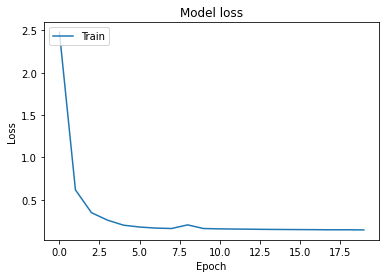

In [9]:
# 绘制训练 & 验证的损失值
plt.plot(History.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [10]:
if mode==1:
    score = model.evaluate([Intest,OutLtest],[Outtest,OutLtest])
    print('Loss:', score)
if mode==2:
    score = model.evaluate([Intest,OutLtest],[Intest,Outtest,OutLtest])
    print('Loss:', score)
if mode==3:
    score = model.evaluate([Intest,OutLtest],[Outtest,Outtest,OutLtest])
    print('Loss:', score)

1047/1047 [==============================] - 0s 376us/sample - loss: 0.1612 - dense2_loss: 0.0065 - dense4_loss: 0.1478 - softmax_loss: 4.5608e-04
Loss: [0.16121794374476417, 0.006467463, 0.1477861, 0.00045608444]


# 可视化

In [ ]:
# 可视化参数设置
FDE1,FDE3,FDE5 = [],[],[]
ADE1,ADE3,ADE5 = [],[],[]
i=28 # 可视化的样本

In [11]:
if style == 'En':
    if mode == 2 or 3:
        vis1,_,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
        vis2,_,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
        vis3,_,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])
    if mode == 1:
        vis1,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
        vis2,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
        vis3,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])
        
    print(act1,act2,act3)

    avis1 = vis1[0].swapaxes(0, 1)
    avis2 = vis2[0].swapaxes(0, 1)
    avis3 = vis3[0].swapaxes(0, 1)
    aIntest = Intest101[i].swapaxes(0, 1)
    aOuttest = Outtest101[i].swapaxes(0, 1)

    plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
    plt.scatter(avis1[1], avis1[0], lw=2, label="Left")
    plt.scatter(avis2[1], avis2[0], lw=2, label="Keep")
    plt.scatter(avis3[1], avis3[0], lw=2, label="Right")
    plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

    plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('trajectory')
    plt.ylabel('horizontal')
    plt.xlabel('longitudinal')
    plt.legend()
    plt.show()

In [ ]:
if style == 'Inc':    
    if mode == 2 or mode == 3:
        vis1,_,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
        vis2,_,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
        vis3,_,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])
    elif mode == 1:
        vis1,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
        vis2,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
        vis3,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])

    print(act1,act2,act3)
    # 逆归一化
    if index ==0:
        minx,miny,maxx,maxy = -0.08069654511150287,0.0,0.05337498582371923,0.0901874766834021
    if index ==1:
        minx,miny,maxx,maxy = -0.05825761624799569,0.0,0.05758570665037799,0.059151017599056055
    ir_vis1 = vis1[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny]) 
    ir_vis2 = vis2[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])
    ir_vis3 = vis3[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])
#     print(ir_vis1,'\n\n',ir_vis2,'\n\n',ir_vis3)
    # 逆增量化
    for j in range(Intrain.shape[1]):
        ir_vis1[j] += OutStest[i][j] if j==0 else ir_vis1[j-1]
        ir_vis2[j] += OutStest[i][j] if j==0 else ir_vis2[j-1]
        ir_vis3[j] += OutStest[i][j] if j==0 else ir_vis3[j-1]

    avis1 = ir_vis1.swapaxes(0, 1)
    avis2 = ir_vis2.swapaxes(0, 1)
    avis3 = ir_vis3.swapaxes(0, 1)
    aIntest = InStest[i].swapaxes(0, 1)
    aOuttest = OutStest[i].swapaxes(0, 1)

    plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
    plt.scatter(avis1[1], avis1[0], lw=2, label="Left")
    plt.scatter(avis2[1], avis2[0], lw=2, label="Keep")
    plt.scatter(avis3[1], avis3[0], lw=2, label="Right")
    plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

    plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
    plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('trajectory')
    plt.ylabel('horizontal')
    plt.xlabel('longitudinal')
    plt.legend()
    plt.show()

    if index == 0:
        minx,maxx,miny,maxy = 0.003,96.996, 0.0, 444.962
    elif index == 1:
        minx,maxx,miny,maxy = 3.598, 69.083, 1584.308, 2235.252
    ratio = 0.3048

    # 再逆归一化，以此单位米化
    if OutLtest[i][0]==1:
        ir_vis = ir_vis1
    if OutLtest[i][1]==1:
        ir_vis = ir_vis2
    if OutLtest[i][2]==1:
        ir_vis = ir_vis3

    irir_vis = (ir_vis * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])) * ratio
    ir_OutStest = (OutStest[i] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])) * ratio
    l1 = np.abs(irir_vis - ir_OutStest)
#     FDE = np.power((np.power(l1[...,0],2)+np.power(l1[...,1],2)),0.5)
    FDE = ((l1[...,0])**2 + (l1[...,1])**2)**0.5
    print(FDE)
    print('1s error: %fm; 3s error: %fm; 5s error: %fm;'%(FDE[1],FDE[5],FDE[-1]))
    print('1s error: %fm; 3s error: %fm; 5s error: %fm;'%(np.mean(FDE[0:1]),np.mean(FDE[0:5]),np.mean(FDE[0:-1])))

# 误差分析

In [12]:
for i in range(Intest.shape[0]):
    if style == 'Inc':    
        if mode == 2 or mode == 3:
            vis1,_,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
            vis2,_,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
            vis3,_,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])
        elif mode == 1:
            vis1,act1 = model.predict([[Intest[i]], np.array([[1, 0, 0]])])
            vis2,act2 = model.predict([[Intest[i]], np.array([[0, 1, 0]])])
            vis3,act3 = model.predict([[Intest[i]], np.array([[0, 0, 1]])])

#         print(act1,act2,act3)
        # 逆归一化
        if index ==0:
            minx,miny,maxx,maxy = -0.08069654511150287,0.0,0.05337498582371923,0.0901874766834021
        if index ==1:
            minx,miny,maxx,maxy = -0.05825761624799569,0.0,0.05758570665037799,0.059151017599056055
        ir_vis1 = vis1[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny]) 
        ir_vis2 = vis2[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])
        ir_vis3 = vis3[0] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])
    #     print(ir_vis1,'\n\n',ir_vis2,'\n\n',ir_vis3)
        # 逆增量化
        for j in range(Intrain.shape[1]):
            ir_vis1[j] += OutStest[i][j] if j==0 else ir_vis1[j-1]
            ir_vis2[j] += OutStest[i][j] if j==0 else ir_vis2[j-1]
            ir_vis3[j] += OutStest[i][j] if j==0 else ir_vis3[j-1]

        avis1 = ir_vis1.swapaxes(0, 1)
        avis2 = ir_vis2.swapaxes(0, 1)
        avis3 = ir_vis3.swapaxes(0, 1)
        aIntest = InStest[i].swapaxes(0, 1)
        aOuttest = OutStest[i].swapaxes(0, 1)

#         plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
#         plt.scatter(avis1[1], avis1[0], lw=2, label="Left")
#         plt.scatter(avis2[1], avis2[0], lw=2, label="Keep")
#         plt.scatter(avis3[1], avis3[0], lw=2, label="Right")
#         plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

#         plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
#         plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
#         plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
#         plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

#         plt.xlim(0, 1)
#         plt.ylim(0, 1)
#         plt.title('trajectory')
#         plt.ylabel('horizontal')
#         plt.xlabel('longitudinal')
#         plt.legend()
#         plt.show()

        if index == 0:
            minx,maxx,miny,maxy = 0.003,96.996, 0.0, 444.962
        elif index == 1:
            minx,maxx,miny,maxy = 3.598, 69.083, 1584.308, 2235.252
        ratio = 0.3048

        # 再逆归一化，以此单位米化
        if OutLtest[i][0]==1:
            ir_vis = ir_vis1
        if OutLtest[i][1]==1:
            ir_vis = ir_vis2
        if OutLtest[i][2]==1:
            ir_vis = ir_vis3

        irir_vis = (ir_vis * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])) * ratio
        ir_OutStest = (OutStest[i] * np.array([maxx-minx,maxy-miny]) + np.array([minx,miny])) * ratio
        l1 = np.abs(irir_vis - ir_OutStest)
        FDE = np.power((np.power(l1[...,0],2)+np.power(l1[...,1],2)),0.5)
        FDE1.append(FDE[1])
        FDE3.append(FDE[5])
        FDE5.append(FDE[-1])
        ADE1.append(np.mean(FDE[0:1]))
        ADE3.append(np.mean(FDE[0:5]))
        ADE5.append(np.mean(FDE[0:-1]))
#         print(FDE)
#         print('1s error: %fm; 3s error: %fm; 5s error: %fm;'%(FDE[1],FDE[5],FDE[-1]))
#         print('1s error: %fm; 3s error: %fm; 5s error: %fm;'%(np.mean(FDE[0:1]),np.mean(FDE[0:5]),np.mean(FDE[0:-1])))

In [14]:
meanFDE1 = np.mean(FDE1)
meanFDE3 = np.mean(FDE3)
meanFDE5 = np.mean(FDE5)
meanADE1 = np.mean(ADE1)
meanADE3 = np.mean(ADE3)
meanADE5 = np.mean(ADE5)
print(meanFDE1,',',meanFDE3,',',meanFDE5,',',meanADE1,',',meanADE3,',',meanADE5)
FDE1=np.array(FDE1)
FDE3 = np.array(FDE3)
FDE5 = np.array(FDE5)
ADE1 = np.array(ADE1)
ADE3 = np.array(ADE3)
ADE5 = np.array(ADE5)
print(np.median(FDE1),',',np.median(FDE3),',',np.median(FDE5),',',np.median(ADE1),',',np.median(ADE3),',',np.median(ADE5))
print(np.percentile(FDE1,1),',',np.percentile(FDE3,3),',',np.percentile(FDE5,6),',',np.percentile(ADE1,0.75),',',np.percentile(ADE1,1.5),',',np.percentile(ADE1,3.5))

0.8113661371455002 , 3.4279254729263884 , 5.899992545829476 , 0.05086142739220043 , 1.4783849411244172 , 2.7596288369662365
0.7441409660383893 , 2.421822665879699 , 4.421785426420074 , 0.05086142739222833 , 1.0158634495150896 , 2.0308776031327307
0.0355043225877754 , 0.4169009221789967 , 0.7997113415547998 , 0.05086142739214951 , 0.05086142739214951 , 0.05086142739214951
